# Twirling with Program Sets on mitiq 

In this notebook, we look at Pauli twirling for normalizing noise on gates and measurement, and specifically how this can be realized using [Mitiq](https://mitiq.readthedocs.io/en/stable/) with Amazon Braket. 

### Installing Mitiq

>mitiq is not included by default with `amazon-braket-examples` requirements or in the Amazon Braket Notebook Instances. To install, uncomment the first line in the next code block, and restart the notebook. Or run install from `extra/requirement-mitiq.txt`. 

Mitiq utilizes Cirq as the backend, and may represent circuits using their representation. 

In [ ]:
# %pip install mitiq cirq-ionq
try:
    import mitiq  # noqa: F401
    print("Package 'mitiq' is installed.")
except ImportError:
    print("!! Package 'mitiq' is not installed !!")

Package 'mitiq' is installed.


We also provide necessary imports, particularly `mitiq.pt.generate_pauli_twirl_variants`. 

In [ ]:
import os
import sys

import numpy as np

from braket.circuits import Circuit
from braket.circuits.observables import I, X, Y, Z
from braket.devices import LocalSimulator
from braket.program_sets import ProgramSet

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))) # parent directory 
import matplotlib.pyplot as plt
from mitiq.pt import generate_pauli_twirl_variants
from qiskit_braket_provider import to_braket
from tools.mitigation_tools import apply_readout_twirl, process_readout_twirl
from tools.noise_models import qd_amp
from tools.observable_tools import matrix_to_pauli


### Overview of Pauli twirling

Pauli twirling is a technique used widely across quantum learning and mitigation protocols, known for it's simplicity and effectiveness (see [Wallman and Emerson](https://arxiv.org/pdf/1512.01098)). Essentially, twirling with classes of channels allows us to control and shape the noise channel. As a result, we can increase confidence in our knowledge of the channel and subsequent mitigation. As implied in the name, Pauli twirling refers to twirling with elements of the Pauli group (i.e. tensor products of single-qubit Pauli matrices). When acting on a channel, the noise channel becomes diagonalized in the superoperator basis of Pauli matrices, or the Pauli transfer representation. 

Specifically, we use the channel notation $\mathcal{E}[ \cdot] $, to denote the operation of a quantum channel on a density matrix. The twirling operation (which we define as $\mathcal{F}_P$, and whose inputs are quantum channels) is defined as:

$ \mathcal{F}[\mathcal{E}[\cdot ]] = \frac{1}{|P|}\sum_{\sigma  \in P} \mathcal{E}_\sigma \circ \mathcal{E} \circ \mathcal{E}_\sigma [\cdot]  $

where $\circ$ denotes channel composition. Importantly, we have $|P|$ distinct sums, which for the Pauli group is $4^N$. This exact twirling of noise channels themselves is generally not implementable except for extremely small systems, as it is an operation on the superoperator space involving an exponentially large number of elements of the twirling set. Instead, we approximate the twirling process sampling from elements of $P$. 

### Implementing Pauli twirling for gates

We first consider a single instance of twirling. Specifically we are interested in turning a noisy operation $\mathcal{E}_N$ into $\mathcal{E}_\sigma \circ \mathcal{E}_N \circ \mathcal{E}_\sigma$. Let $\tilde{\mathcal{E}}_U$ denote the noisy application of a unitary channel $U$. Then, we can write this in terms of a before-gate noise $\mathcal{E}_N$ composed with the unitary:

$$\tilde{\mathcal{E}}_{U} =  \mathcal{E}_U \circ \mathcal{E}_N$$

To twirl this, we ideally would apply a Pauli channel as follow:

$ \mathcal{E}_{twirl} = \sum_{\sigma \in \mathbb{P}} \mathcal{E}_U \circ \mathcal{E}_\sigma \circ \mathcal{E}_N \circ \mathcal{E}_\sigma $

However, we can't access the noise channel directly, and so we can instead commute (or anti-commute) these Paulis through the CNOT gate. This gives the following input and output Pauli twirls:

| $\sigma_i$ | II  | IX  | IY  | IZ  | XI  | XX  | XY  | XZ  | YI  | YX  | YY  | YZ  | ZI  | ZX  | ZY  | ZZ  |
| ---------- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| $\sigma_o$ | II  | IX  | ZY  | ZZ  | XX  | XI  | YZ  | YY  | YX  | YI  | XZ  | XY  | ZI  | ZX  | IY  | IZ |

Practically, we realize this by sampling the above input and output channel per each CNOT, and placing them before and after each Pauli. The CNOTs operations are preserved up to a global phase. We can verify this below: 

In [ ]:
cnot = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
])

ps = [I(),X(),Y(),Z()]

for i in ps:
    for j in ps:
        print(
            'inp -> out: ',
            matrix_to_pauli((i @ j).to_matrix())[0][1],'->',
            matrix_to_pauli(cnot @ (i @ j).to_matrix() @ cnot)[0][1])

inp -> out:  II -> II
inp -> out:  IX -> IX
inp -> out:  IY -> ZY
inp -> out:  IZ -> ZZ
inp -> out:  XI -> XX
inp -> out:  XX -> XI
inp -> out:  XY -> YZ
inp -> out:  XZ -> YY
inp -> out:  YI -> YX
inp -> out:  YX -> YI
inp -> out:  YY -> XZ
inp -> out:  YZ -> XY
inp -> out:  ZI -> ZI
inp -> out:  ZX -> ZX
inp -> out:  ZY -> IY
inp -> out:  ZZ -> IZ


> Twirling in this way can only be done exactly for elements that are preserved under this group action. Specifically, we have that the Pauli elements are preserved under arbitrary Clifford operations (definition of the Clifford group). Taking a non-Clifford gate, like $R_z$ with arbitrary angles, will not preserve the Paulis.  

With Mitiq, we can input a Circuit with CNOT gates or CZ gates, and then apply twirls using `generate_pauli_twirl_variants`. More details can be found in the Mitiq [documentation on Pauli twirling](https://mitiq.readthedocs.io/en/stable/guide/pt.html). 

In [4]:

test = Circuit().cnot(0,1)
variants = generate_pauli_twirl_variants(test,3)
for i in variants:
    print(i)

T  : │  0  │  1  │  2  │
      ┌───┐       ┌───┐ 
q0 : ─┤ Z ├───●───┤ Z ├─
      └───┘   │   └───┘ 
      ┌───┐ ┌─┴─┐ ┌───┐ 
q1 : ─┤ I ├─┤ X ├─┤ I ├─
      └───┘ └───┘ └───┘ 
T  : │  0  │  1  │  2  │
T  : │  0  │  1  │  2  │
      ┌───┐       ┌───┐ 
q0 : ─┤ Y ├───●───┤ X ├─
      └───┘   │   └───┘ 
      ┌───┐ ┌─┴─┐ ┌───┐ 
q1 : ─┤ Y ├─┤ X ├─┤ Z ├─
      └───┘ └───┘ └───┘ 
T  : │  0  │  1  │  2  │
T  : │  0  │  1  │  2  │
      ┌───┐       ┌───┐ 
q0 : ─┤ I ├───●───┤ Z ├─
      └───┘   │   └───┘ 
      ┌───┐ ┌─┴─┐ ┌───┐ 
q1 : ─┤ Y ├─┤ X ├─┤ Y ├─
      └───┘ └───┘ └───┘ 
T  : │  0  │  1  │  2  │


For smaller systems, we can sometime enumerate all potential twirls, or use smaller twirling sets, but as the number of unique circuits scales as $16^{N_{CNOTS}}$, this is quickly intractable. Thus, we just sample different Pauli twirled variants and reconstruct them. Again, these Pauli twirled variants all represent the same logical circuit, and act to homogenize the noise channel to a Pauli channel. 

In [5]:

length_bell = 20
depth = 2
 
test = Circuit().h(0).cnot(0,1)

def ghz_layer(i,j):
    return Circuit().cnot(i,j).h(i).h(j).cnot(j,i)


for i in range(length_bell//2):
    test+= ghz_layer(0,1)

print(test)


T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │  9  │ 10  │ 11  │ 12  │ 13  │ 14  │ 15  │ 16  │ 17  │ 18  │ 19  │ 20  │ 21  │ 22  │ 23  │ 24  │ 25  │ 26  │ 27  │ 28  │ 29  │ 30  │ 31  │
      ┌───┐             ┌───┐ ┌───┐       ┌───┐ ┌───┐       ┌───┐ ┌───┐       ┌───┐ ┌───┐       ┌───┐ ┌───┐       ┌───┐ ┌───┐       ┌───┐ ┌───┐       ┌───┐ ┌───┐       ┌───┐ ┌───┐       ┌───┐ ┌───┐ 
q0 : ─┤ H ├───●─────●───┤ H ├─┤ X ├───●───┤ H ├─┤ X ├───●───┤ H ├─┤ X ├───●───┤ H ├─┤ X ├───●───┤ H ├─┤ X ├───●───┤ H ├─┤ X ├───●───┤ H ├─┤ X ├───●───┤ H ├─┤ X ├───●───┤ H ├─┤ X ├───●───┤ H ├─┤ X ├─
      └───┘   │     │   └───┘ └─┬─┘   │   └───┘ └─┬─┘   │   └───┘ └─┬─┘   │   └───┘ └─┬─┘   │   └───┘ └─┬─┘   │   └───┘ └─┬─┘   │   └───┘ └─┬─┘   │   └───┘ └─┬─┘   │   └───┘ └─┬─┘   │   └───┘ └─┬─┘ 
            ┌─┴─┐ ┌─┴─┐ ┌───┐   │   ┌─┴─┐ ┌───┐   │   ┌─┴─┐ ┌───┐   │   ┌─┴─┐ ┌───┐   │   ┌─┴─┐ ┌───┐   │   ┌─┴─┐ ┌───┐   │   ┌─┴─┐ ┌───┐   │   ┌─┴─┐ ┌───┐   │   ┌─┴─┐ ┌───┐   │   ┌─┴─┐ ┌───┐   │   
q1 : 

In [6]:
pt_mitiq = generate_pauli_twirl_variants(test, num_circuits=1)
pt_mitiq_verb = to_braket(pt_mitiq, optimization_level=1, basis_gates=["r","cz"],qubit_labels=[1,2])[0]

print(pt_mitiq_verb)

T  : │          0          │         1         │  2  │          3          │         4         │  5  │          6          │         7         │  8  │          9          │        10         │ 11  │         12         │ 13  │         14          │        15         │ 16  │         17         │         18         │ 19  │         20          │        21         │ 22  │         23          │        24         │ 25  │         26         │         27         │ 28  │        29         │ 30  │        31         │        32         │ 33  │         34          │        35         │ 36  │        37         │ 38  │         39         │ 40  │         41          │        42         │ 43  │         44         │         45         │ 46  │         47         │         48         │ 49  │         50          │        51         │ 52  │         53         │        54         │ 55  │         56         │        57         │ 58  │         59          │        60         │ 61  │
      ┌───────────────────┐

/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:853: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn("The Qiskit circuit contains barrier instructions that are ignored.")
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


####  Running twirled circuits 

To compare, let's take a CNOT generating circuit with a simple amplitude damping noise model, and then consider deeper circuits. 

In the noisy case we have:

[[0.4938 0.0247 0.0249 0.4566]
 [0.4879 0.0409 0.0421 0.4291]
 [0.519  0.0587 0.0598 0.3625]
 [0.4962 0.0724 0.0672 0.3642]
 [0.5181 0.0798 0.0828 0.3193]
 [0.5078 0.0938 0.0869 0.3115]
 [0.5306 0.1054 0.0971 0.2669]
 [0.5211 0.1135 0.1049 0.2605]
 [0.5499 0.1229 0.0999 0.2273]
 [0.5292 0.128  0.1179 0.2249]]


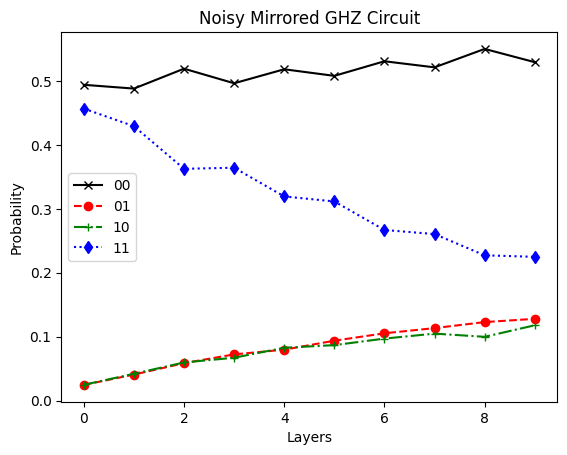

In [18]:
test = Circuit()


evs = np.zeros((10,4))
for i in range(10):
    if i==0:
        test+= Circuit().h(0).cnot(0, 1)
    else:
        test+= Circuit().cnot(0,1).h(0).h(1).cnot(1,0)
    res = qd_amp.run(test, shots = 10000,).result().measurement_probabilities
    evs[i,:] = [res.get(f"{k:02b}",0) for k in range(4)]

print(evs)

for i,label, color, ls, m in zip(range(4),["00", "01", "10", "11"], ["k", "r", "g", "b"], ["-", "--", "-.", ":"], ['x','o','+','d']):
    plt.plot(range(10),evs[:,i], label=label, c=color, ls=ls, marker=m)
plt.title("Noisy Mirrored GHZ Circuit")
plt.ylabel("Probability")
plt.xlabel("Layers")
plt.legend()


To contrast, we can perform the same experiment again, now with Pauli twirling:

[[0.47903 0.03217 0.01677 0.47203]
 [0.47238 0.04409 0.0382  0.44533]
 [0.43207 0.07864 0.06714 0.42215]
 [0.41764 0.08585 0.07536 0.42115]
 [0.41149 0.0928  0.1282  0.36751]
 [0.39043 0.11535 0.11139 0.38283]
 [0.37326 0.14281 0.1298  0.35413]
 [0.37062 0.1374  0.1504  0.34158]
 [0.33269 0.1551  0.17205 0.34016]
 [0.32055 0.19417 0.16296 0.32232]]


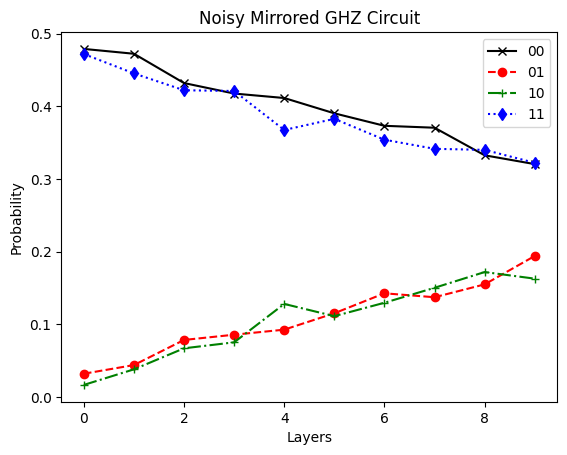

In [ ]:
test = Circuit()

n_twirls = 10

evs = np.zeros((10,4, n_twirls))
for i in range(10):
    if i==0:
        test+= Circuit().h(0).cnot(0, 1)
    else:
        test+= Circuit().cnot(0,1).h(0).h(1).cnot(1,0)
    variants = generate_pauli_twirl_variants(test, num_circuits=n_twirls)


    for j in range(n_twirls):
        res = qd_amp.run(variants[j], shots = 100000//n_twirls,).result().measurement_probabilities
        evs[i,:,j] = [res.get(f"{k:02b}",0) for k in range(4)]


evs = np.average(evs, axis = -1)
print(evs)

for i,label, color, ls, m in zip(range(4),["00", "01", "10", "11"], ["k", "r", "g", "b"], ["-", "--", "-.", ":"], ['x','o','+','d']):
    plt.plot(range(10),evs[:,i], label=label, c=color, ls=ls, marker=m)
plt.title("Noisy Mirrored GHZ Circuit")
plt.ylabel("Probability")
plt.xlabel("Layers")
plt.legend()


Thus we see that the effect of noise is largely normalized - each channel exhibits straightforward decay. To truly verify that we have eliminated coherent errors we can consider how the channel acts on different input states - effectively corresponding with quantum process tomography. 

>Generally, the most performant way to twirling on Braket today is the above manner, with discrete circuits. 

### Measurement twirling 

Measurement twirling follows on bitflip averaging ([Smith et al.](https://www.science.org/doi/10.1126/sciadv.abi8009), and [van der Berg et al.](https://arxiv.org/abs/2012.09738)), which does not account for phase related errors, and involves twirling with commuting and non-commuting Pauli elements (see [Hashim et al.](https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.6.010307)). 

Noise on measurement is slightly different, as our twirl will involve both classical and quantum information. Here we show how to `twirl` measurement channels. In a similar spirit, this can effectively translate any output measurement channel to a bitflip channel. 

$\mathcal{E}_M[\rho] = |0\rangle \langle 0 | \rho |0\rangle \langle 0 | + |1\rangle \langle 1| \rho |1 \rangle \langle 1 | = |1\rangle \langle 1| {\rm Tr} |1\rangle \langle 1 | \rho  + |0\rangle \langle 0| {\rm Tr} |0\rangle \langle 0 | \rho $ 
 
We can further write this in the Pauli basis:

$\mathcal{E}_M[\rho] = 0.25 * (I+Z) {\rm Tr} (I + Z) \rho  + 0.25 * (I-Z) {\rm Tr} (I-Z) \rho = \frac{1}{2} I + \frac{1}{2}Z  {\rm Tr} Z \rho $ 


Application of a Pauli before and after the channel transforms this to:

$\mathcal{E}_\sigma \mathcal{E}_M \mathcal{E}_\sigma[\rho] = 0.25 * (I+\bar Z)  {\rm Tr} (I + \bar Z) \rho + 0.25 * (I- \bar{Z}) {\rm Tr} (I-\bar{Z}) \rho $ 

where $\bar{Z} = \sigma Z \sigma $, and can be written as ${-1}^{\langle Z, \sigma \rangle }$. Importantly, if $\sigma$ anticommutes, i.e. with $\sigma = X$ or $\sigma = Y$. 

Beyond the $Z$ basis, this holds for any Pauli observable - i.e. if we rotate to the $X$ basis, then we will find that $Z$ and $Y$ anticommute. While we can actually apply a gate after measurement, the proper way to carry this out is to perform this virtually, as we are interested in the classical information. Intuitively, for the $Z$ basis, if we apply an X gate before measuring $|\psi\rangle = |0\rangle$, we expect to recover the $|1\rangle\langle 1|$ state. We can then apply a post-correction to flip our classical result to the opposite Pauli eigenstate, i.e. $|0\rangle \langle 0|$. To generalize this beyond $Z$, for an arbitrary tensored single-qubit Pauli basis measurement with outcomes $|k_0 k_1... k_n\rangle\langle k_0 k_1... k_n|$, we can flip indices where the Pauli twirl $\sigma_i$ anti-commutes with the measurement basis $|k_i\rangle$. This generalizes the measurement twirl procedure beyond the computational basis.

|  | Basis    | I   | X    | Y    | Z    |
| ----------------- | --- | --- | ---- | ---- | ---- |
| Twirl             | I   | --  | --   | --   | --   |
|                   | X   | --  | --   | Flip | Flip |
|                   | Y   | --  | Flip | --   | Flip |
|                   | Y   | --  | Flip | Flip | --   |

#### Performing measurement twirling

To perform this, we will utilize some prebuilt tools, namely `tools/apply_readout_twirl`. 


In [28]:

circ = Circuit().z(0).z(1)
n_ro_twirls = 5
circuits, paulis  = apply_readout_twirl(circ, n_ro_twirls)
print(paulis)
print(circuits[0])

('YZ', 'IY', 'YY', 'IZ', 'YI')
T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ Z ├─┤ Y ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ Z ├─┤ Z ├─
      └───┘ └───┘ 
T  : │  0  │  1  │


Now, we will convert our Pauli twirls to "bit_masks", i.e. directions for telling how to flip the outcomes. Because we are making a simple $Z$ measurement, we only need to convert if the twirl is X or Y. 

In [32]:

bit_masks = np.zeros(n_ro_twirls, dtype=object)
bases = ["ZZ"]
for i in range(n_ro_twirls):
    bit_masks[i] = "".join(["0" if paulis[i][j] in "IZ" else "1" for j in range(len(paulis[i]))])

print(paulis)
print(bit_masks)



('YZ', 'IY', 'YY', 'IZ', 'YI')
['10' '01' '11' '00' '10']


Finally, we process these arrays. This simply involves adding (via bit addition) the bit mask string to the keys of the output dictionary, this will model the effect of the twirl. `process_readout_twirl` takes a dictionary, as well as the index and a `bit_mask` array, though this can be hard coded in a straightforward manner as well. 

In [45]:

ps = ProgramSet(circuits, shots_per_executable=100)
results = LocalSimulator().run(ps).result()
print('Twirled counts:')
for item in results:
    print(item[0].counts)

counts = {}
for i, result in enumerate(results):
    for k,v in process_readout_twirl(result[0].counts, i, bit_masks).items():
        counts[k] = v + counts.get(k, 0)

print('\nAdjusted counts: ')
print(counts)


Twirled counts:
Counter({'10': 100})
Counter({'01': 100})
Counter({'11': 100})
Counter({'00': 100})
Counter({'10': 100})

Adjusted counts: 
{'00': 500}


The effect of this is to normalize bit transitions - this can be used with `mitiq.rem` post processing to apply a readout correction as well. 

#### A short aside on variance 

Twirling, when carried out as a randomized process, can be understood as a random variable with some inherent statistics. Generally, this is overlooked, as this sampling error can be composed into other errors within the workflow relatively easily. In principle, fluctuations from twirling occur due to the distance between the raw channel and the twirled channel. This results in a broadening of the variance, though typically this is thought to be on the same order of magnitude as sampling, and is typically less than the exponential overheads for quantum error mitigation techniques. 

For instance, a channel that is very far from a Pauli channel, might act on one input very minimally, but when twirled, change the relative behavior and error rates substantially. In many instances, twirling is shown to converge quite quickly, though this is something users should be aware of. 


### Summary 

In this notebook we took a simple dive into Pauli twirling, and how we can generate Pauli twirled variants of our circuits. 

### References

1. Wallman, Emersen, [**Noise tailoring for scalable quantum computation via randomized compiling**](https://arxiv.org/abs/1512.01098) (2015), Phys. Rev. A. 94, 052325. 
2. Unitary Foundation, [**Mitiq Guide, Pauli twirling**](https://mitiq.readthedocs.io/en/stable/guide/pt.html), Accessed 12/9/2025. 
3. Hashim et al., [**Quasiprobabilistic Readout Correction of Midcircuit Measurements for Adaptive Feedback via Measurement Randomized Compiling**](https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.6.010307) (2025) PRX Quantum, 6, 010307. 
4. Smith et al., [**Qubit readout error mitigation with bit-flip averaging**](https://www.science.org/doi/10.1126/sciadv.abi8009) (2021) Sci. Advances, 7, 47. 
